In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)

In [4]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_v1_base.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]


existing_hparams = TSTInfo.get_existing_hparams()
seeds = np.unique([h["seed"] for h in existing_hparams])
signal_ratios = np.unique([h["signal_ratio"] for h in existing_hparams])
n_3bs = np.unique([h["n_3b"] for h in existing_hparams])
noise_scales = np.unique([h["SRCR"]["noise_scale"] for h in existing_hparams])

In [19]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from plots import calibration_plot

n_3b = 100_000
signal_ratio = 0.05

verbose = True
show_plots = True
hparam_filter = {
    "experiment_name": experiment_name,
    "n_3b": n_3b,
    "signal_ratio": signal_ratio,
    # "seed": lambda x: x in list(range(5)),
    "SRCR": lambda x: x.get("noise_scale") in [0.001, 0.01, 1],
}
hashes = TSTInfo.find(hparam_filter)

w_4b_cuts = np.arange(0.05, 1, 0.05)
w_signals = []

for tstinfo_hash in tqdm.tqdm(hashes):
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    noise_scale = tstinfo.hparams["SRCR"]["noise_scale"]

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    SR_stats_argsort = np.argsort(tstinfo.SR_stats)[::-1]
    
    ratio_4b = np.cumsum((events_tst.is_4b * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_4b
    ratio_signal = np.cumsum((events_tst.is_signal * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_signal
    
    for w_4b_cut in w_4b_cuts:
        pos = np.argmin(ratio_4b < w_4b_cut)
        w_signal = ratio_signal[pos]
        w_signals.append({"w_signal": w_signal, "w_4b_cut": w_4b_cut, "seed": seed, 
                          "signal_ratio": signal_ratio, "n_3b": n_3b, "noise_scale": noise_scale
                          })

w_signal_df = pd.DataFrame(w_signals)

100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


[]

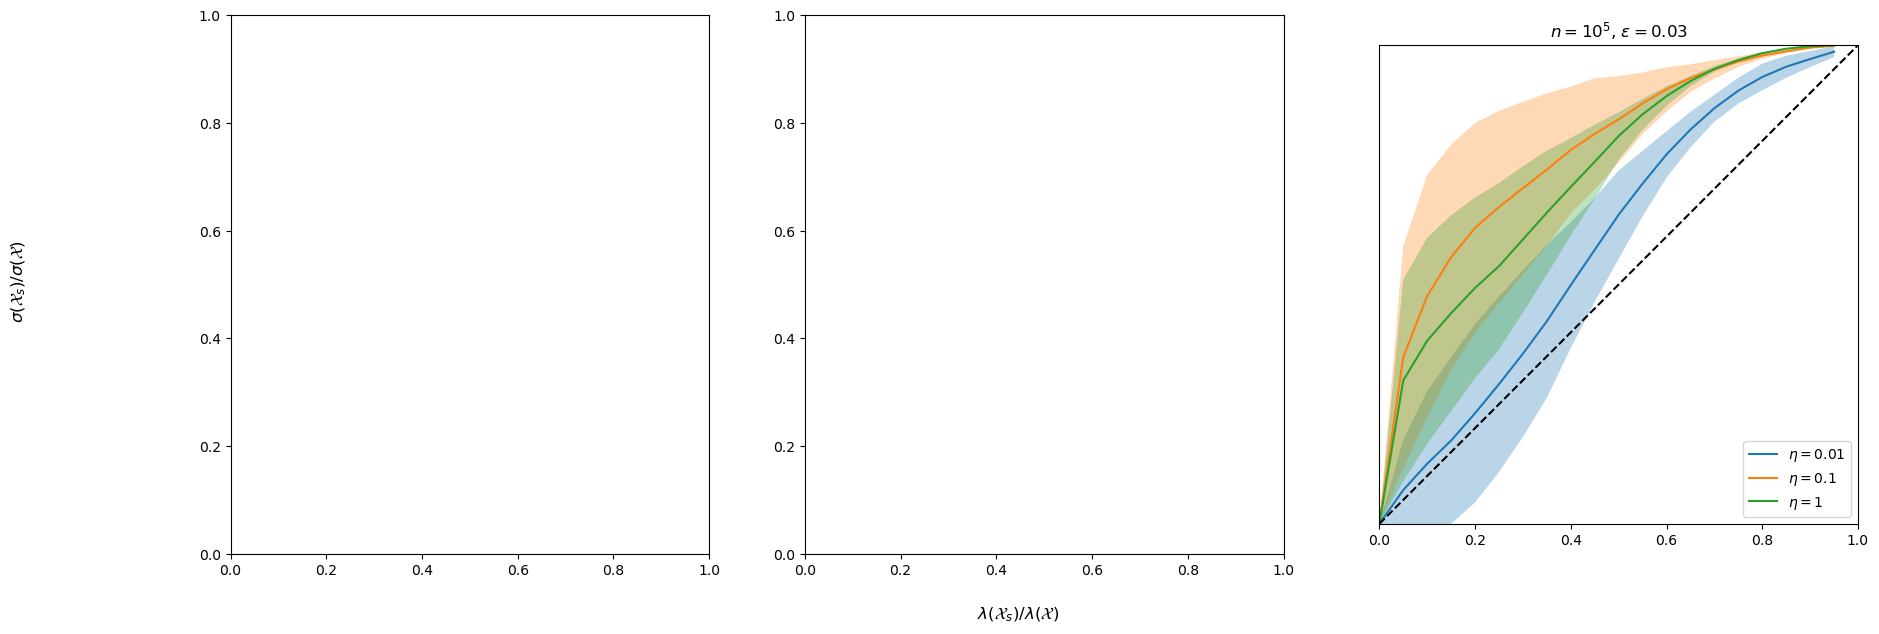

In [22]:
w_signal_mean = w_signal_df.groupby(["signal_ratio", "n_3b", "noise_scale", "w_4b_cut"])["w_signal"].mean()
w_signal_std = w_signal_df.groupby(["signal_ratio", "n_3b", "noise_scale", "w_4b_cut"])["w_signal"].std()

def get_w_signal(signal_ratio, n_3b, noise_scale):
    mean_series = w_signal_mean.loc[(signal_ratio, n_3b, noise_scale)]
    std_series = w_signal_std.loc[(signal_ratio, n_3b, noise_scale)]
    return np.insert(mean_series.index, 0, 0), np.insert(mean_series.values, 0, 0), np.insert(std_series.values, 0, 0)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))
fig.supxlabel(r"$\lambda(\mathcal{X}_s) / \lambda(\mathcal{X})$")
fig.supylabel(r"$\sigma(\mathcal{X}_s) / \sigma(\mathcal{X})$")

for noise_scale in [0.01, 0.1, 1]:
    idx, mean, std = get_w_signal(0.05, 100_000, noise_scale)
    ax[2].fill_between(idx, mean - std, mean + std, alpha=0.3)
    ax[2].plot(idx, mean, label=rf"$\eta = {noise_scale}$")

ax[2].set_title(r"$n = 10^5$, $\epsilon = 0.03$")
ax[2].plot([0, 1], [0, 1], color="black", linestyle="--")
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0, 1)
ax[2].set_aspect("equal")
ax[2].legend(loc="lower right")
ax[2].set_yticklabels([])
ax[2].set_yticks([])

In [7]:
w_signal_df.to_csv("data/tsv/w_signal_df_noise_scales_0.03.tsv", index=False, sep="\t")

In [ ]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from plots import calibration_plot

verbose = True
show_plots = True
hparam_filter = {
    "experiment_name": experiment_name,
}
hashes = TSTInfo.find(hparam_filter)

w_4b_cuts = np.arange(0.05, 1, 0.05)
w_signals = []

for tstinfo_hash in tqdm.tqdm(hashes):
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    noise_scale = tstinfo.hparams["SRCR"]["noise_scale"]

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    SR_stats_argsort = np.argsort(tstinfo.SR_stats)[::-1]
    
    ratio_4b = np.cumsum((events_tst.is_4b * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_4b
    ratio_signal = np.cumsum((events_tst.is_signal * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_signal
    
    for w_4b_cut in w_4b_cuts:
        pos = np.argmin(ratio_4b < w_4b_cut)
        w_signal = ratio_signal[pos]
        w_signals.append({"w_signal": w_signal, "w_4b_cut": w_4b_cut, "seed": seed, "signal_ratio": signal_ratio})

w_signal_df = pd.DataFrame(w_signals)

In [20]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from plots import calibration_plot

verbose = True
show_plots = True
hparam_filter = {
    "experiment_name": experiment_name,
    "n_3b": 100_0000,
    "signal_ratio": lambda x: x in [0.01, 0.02]
}
hashes = TSTInfo.find(hparam_filter)

w_4b_cuts = np.arange(0.05, 1, 0.05)
w_signals = []

for tstinfo_hash in tqdm.tqdm(hashes):
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    noise_scale = tstinfo.hparams["SRCR"]["noise_scale"]

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    SR_stats_argsort = np.argsort(tstinfo.SR_stats)[::-1]
    
    ratio_4b = np.cumsum((events_tst.is_4b * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_4b
    ratio_signal = np.cumsum((events_tst.is_signal * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_signal
    
    for w_4b_cut in w_4b_cuts:
        pos = np.argmin(ratio_4b < w_4b_cut)
        w_signal = ratio_signal[pos]
        w_signals.append({"w_signal": w_signal, "w_4b_cut": w_4b_cut, "seed": seed, "signal_ratio": signal_ratio})

w_signal_df = pd.DataFrame(w_signals)

w_signal_mean = w_signal_df.groupby(["signal_ratio", "w_4b_cut"])["w_signal"].mean()
w_signal_st = w_signal_df.groupby(["signal_ratio", "w_4b_cut"])["w_signal"].std()

fig, ax = plt.subplots()
for signal_ratio in [0.01, 0.02]:
    tmp_mean_df = w_signal_mean.loc[signal_ratio]
    # insert (0, 0) in the beginning
    tmp_mean_df = pd.concat([pd.Series([0], index=[0]), tmp_mean_df])
    tmp_std_df = w_signal_st.loc[signal_ratio]
    tmp_std_df = pd.concat([pd.Series([0], index=[0]), tmp_std_df])
    # fill between 
    ax.fill_between(tmp_mean_df.index, tmp_mean_df - tmp_std_df, tmp_mean_df + tmp_std_df, alpha=0.3)
    ax.plot(tmp_mean_df.index, tmp_mean_df, label=f"signal_ratio={signal_ratio}")

ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")


ax.set_xlabel("w_4b_cut")
ax.set_ylabel("w_signal")
ax.legend()
plt.show()

0it [00:00, ?it/s]

1500it [00:00, 2057.84it/s]
100%|██████████| 200/200 [05:07<00:00,  1.54s/it]


In [41]:
hparam_filter = {
    "experiment_name": experiment_name,
    "signal_ratio": lambda x: x in [0.01, 0.02, 0.03, 0.04, 0.05]
}
hashes = TSTInfo.find(hparam_filter)

w_4b_cuts = np.arange(0.05, 1, 0.05)
w_signals = []

for tstinfo_hash in tqdm.tqdm(hashes):
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    SR_stats_argsort = np.argsort(tstinfo.SR_stats)[::-1]
    
    ratio_4b = np.cumsum((events_tst.is_4b * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_4b
    ratio_signal = np.cumsum((events_tst.is_signal * events_tst.weights)[SR_stats_argsort]) / events_tst.total_weight_signal

    
    for w_4b_cut in w_4b_cuts:
        pos = np.argmin(ratio_4b < w_4b_cut)
        w_signal = ratio_signal[pos]
        w_signals.append({"w_signal": w_signal, "w_4b_cut": w_4b_cut, "seed": seed, 
                          "signal_ratio": signal_ratio, "n_3b": tstinfo.hparams["n_3b"]})

w_signal_df = pd.DataFrame(w_signals)

0it [00:00, ?it/s]

1500it [00:02, 534.32it/s]
100%|██████████| 700/700 [15:59<00:00,  1.37s/it]


In [58]:
w_signal_df.to_csv("w_signal_df.tsv", index=False, sep="\t")

In [49]:
w_signal_mean = w_signal_df.groupby(["signal_ratio", "n_3b", "w_4b_cut"])["w_signal"].mean()
w_signal_std = w_signal_df.groupby(["signal_ratio", "n_3b", "w_4b_cut"])["w_signal"].std()

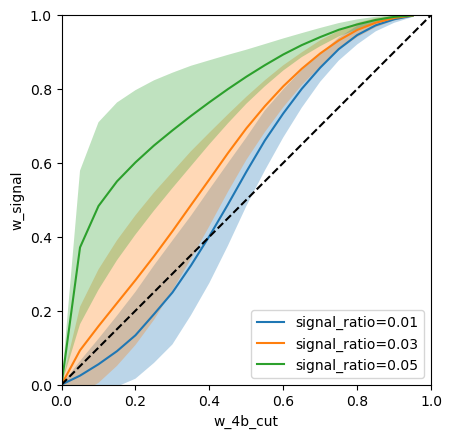

In [53]:
fig, ax = plt.subplots()
for signal_ratio in [0.01, 0.03, 0.05]:
    tmp_mean_df = w_signal_mean.loc[(signal_ratio, 100_000)]
    tmp_mean_df = pd.concat([pd.Series([0], index=[0]), tmp_mean_df])
    tmp_std_df = w_signal_std.loc[(signal_ratio, 100_000)]
    tmp_std_df = pd.concat([pd.Series([0], index=[0]), tmp_std_df])
    # fill between 
    ax.fill_between(tmp_mean_df.index, tmp_mean_df.values - tmp_std_df.values,
                    tmp_mean_df.values + tmp_std_df.values, alpha=0.3)
    ax.plot(tmp_mean_df.index, tmp_mean_df.values, label=f"signal_ratio={signal_ratio}")

ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")


ax.set_xlabel("w_4b_cut")
ax.set_ylabel("w_signal")
ax.legend()
plt.show()

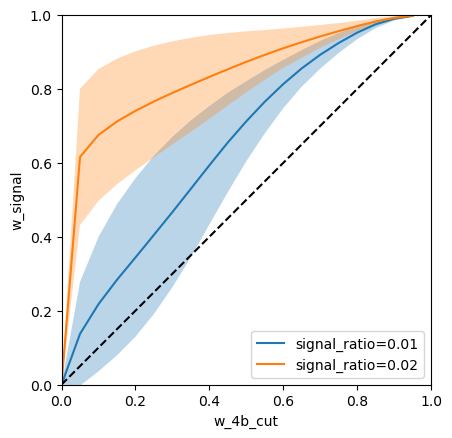

In [56]:
fig, ax = plt.subplots()
for signal_ratio in [0.01, 0.02]:
    tmp_mean_df = w_signal_mean.loc[(signal_ratio, 100_0000)]
    tmp_mean_df = pd.concat([pd.Series([0], index=[0]), tmp_mean_df])
    tmp_std_df = w_signal_std.loc[(signal_ratio, 100_0000)]
    tmp_std_df = pd.concat([pd.Series([0], index=[0]), tmp_std_df])
    # fill between 
    ax.fill_between(tmp_mean_df.index, tmp_mean_df.values - tmp_std_df.values,
                    tmp_mean_df.values + tmp_std_df.values, alpha=0.3)
    ax.plot(tmp_mean_df.index, tmp_mean_df.values, label=f"signal_ratio={signal_ratio}")

ax.plot([0, 1], [0, 1], color="black", linestyle="--")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect("equal")

ax.set_xlabel("w_4b_cut")
ax.set_ylabel("w_signal")
ax.legend()

plt.show()

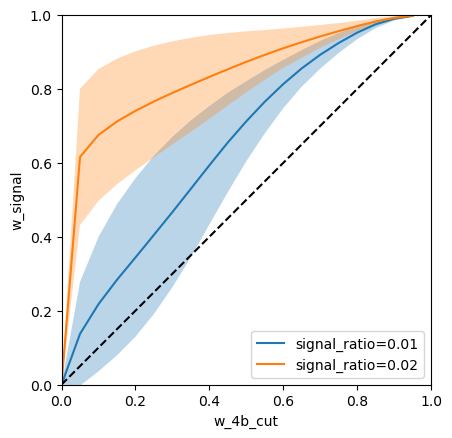